## Data Loading

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Read CSV while excluding the "reference" column
df = pd.read_csv("Dataset.csv")

# Drop the "reference" column if it exists
if "Reference" in df.columns:
    df = df.drop(columns=["Reference"])

# Display the dataframe
print(df.head())


  Dopant    EN    IR  State  NED    FIE  Ratio      MMM   LV   HV  Current  \
0     Mo  2.16  70.0      4   42  684.3  0.114  97.8783  1.0  1.8      0.1   
1     Mo  2.16  70.0      4   42  684.3  0.114  97.8783  1.0  1.8      0.2   
2     Mo  2.16  70.0      4   42  684.3  0.114  97.8783  1.0  1.8      0.5   
3     Mo  2.16  70.0      4   42  684.3  0.114  97.8783  1.0  1.8      1.0   
4     Mo  2.16  70.0      4   42  684.3  0.114  97.8783  1.0  1.8      2.0   

    DC  
0  231  
1  329  
2  297  
3  251  
4  174  


In [36]:
plt.rcParams.update({'font.size': 18})

# Regression

## K-Nearest Neighbors

[I 2025-05-04 11:36:58,624] A new study created in memory with name: no-name-6c4bfbc6-78e5-4cfd-be4d-da0a558b6872


[I 2025-05-04 11:36:58,658] Trial 0 finished with value: 0.09653261539228715 and parameters: {'n_neighbors': 159, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.09653261539228715.
[I 2025-05-04 11:36:58,687] Trial 1 finished with value: 0.08520435781094293 and parameters: {'n_neighbors': 175, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.09653261539228715.
[I 2025-05-04 11:36:58,735] Trial 2 finished with value: 0.30958568614362336 and parameters: {'n_neighbors': 226, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 2 with value: 0.30958568614362336.
[I 2025-05-04 11:36:58,791] Trial 3 finished with value: 0.3574065155264915 and parameters: {'n_neighbors': 295, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 3 with value: 0.3574065155264915.
[I 2025-05-04 11:36:58,821] Trial 4 finished with value: 0.3427791408116163 and parameters: {'n_neighbors': 174, 'weights': 'distance', 'metric': 'euclidean'}. Best

Training Metrics: {'MSE': 168.7921568627451, 'RMSE': 12.992003573842839, 'MAE': 4.2745098039215685, 'R²': 0.9792679596746912, 'Adjusted R²': 0.9788524879246849}
Test Metrics: {'MSE': 1135.8667095325702, 'RMSE': 33.702621701175865, 'MAE': 23.919442000801325, 'R²': 0.8486667016158749, 'Adjusted R²': 0.8295105878963653}


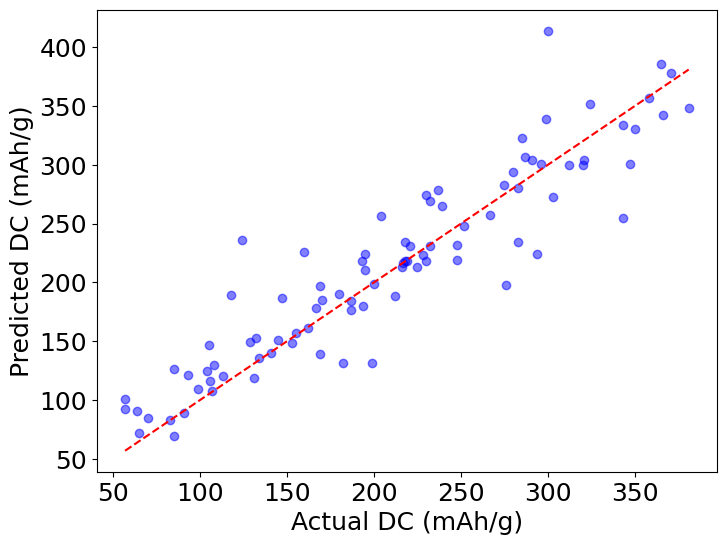

In [38]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold

# --- Data Preprocessing and Splitting ---
# Load your DataFrame as 'df' before executing this code block
# Drop the 'Dopant' column if it exists
if "Dopant" in df.columns:
    df = df.drop(columns=["Dopant"])

# Define target column and feature names
target_column = "DC"
features = df.drop(columns=[target_column]).columns.tolist()

# Extract features (X) and target (y)
X_full = df[features].to_numpy()
y_full = df[target_column].to_numpy()

# Bin target values for stratification
y_full_binned = pd.qcut(y_full, q=10, duplicates='drop', labels=False)

# Split data into training-validation and test sets
X_train_val, X_test, y_train_val, y_test, y_train_val_binned, _ = train_test_split(
    X_full, y_full, y_full_binned, test_size=0.15, random_state=42, stratify=y_full_binned
)

# --- Define Objective Function for Optuna ---
def objective(trial):
    # Suggest hyperparameters for optimization
    n_neighbors = trial.suggest_int("n_neighbors", 1, 300)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    metric = trial.suggest_categorical("metric", ["euclidean", "manhattan", "minkowski"])
    
    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    r2_scores = []
    
    for train_idx, val_idx in skf.split(X_train_val, y_train_val_binned):
        # Split folds and scale features
        X_train_fold, X_val_fold = X_train_val[train_idx], X_train_val[val_idx]
        y_train_fold, y_val_fold = y_train_val[train_idx], y_train_val[val_idx]

        scaler = StandardScaler()
        X_train_fold_scaled = scaler.fit_transform(X_train_fold)
        X_val_fold_scaled = scaler.transform(X_val_fold)

        # Train KNN regressor
        model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, metric=metric)
        model.fit(X_train_fold_scaled, y_train_fold)

        # Predict and compute R² score
        preds = model.predict(X_val_fold_scaled)
        r2_scores.append(r2_score(y_val_fold, preds))
    
    return np.mean(r2_scores)

# --- Hyperparameter Optimization ---
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

# --- Final Model Training ---
scaler_final = StandardScaler()
X_train_val_scaled = scaler_final.fit_transform(X_train_val)
X_test_scaled = scaler_final.transform(X_test)

best_model = KNeighborsRegressor(
    n_neighbors=study.best_params["n_neighbors"],
    weights=study.best_params["weights"],
    metric=study.best_params["metric"]
)
best_model.fit(X_train_val_scaled, y_train_val)

# --- Evaluate on Training Data ---
y_pred_train_val = best_model.predict(X_train_val_scaled)

# Training metrics
n_train = X_train_val.shape[0]
p_train = X_train_val.shape[1]
train_metrics = {
    "MSE": mean_squared_error(y_train_val, y_pred_train_val),
    "RMSE": np.sqrt(mean_squared_error(y_train_val, y_pred_train_val)),
    "MAE": mean_absolute_error(y_train_val, y_pred_train_val),
    "R²": r2_score(y_train_val, y_pred_train_val),
    "Adjusted R²": 1 - (1 - r2_score(y_train_val, y_pred_train_val)) * (n_train - 1) / (n_train - p_train - 1)
}
print("Training Metrics:", train_metrics)

# --- Evaluate on Test Data ---
y_pred_test = best_model.predict(X_test_scaled)

# Test metrics
n_test = X_test.shape[0]
p_test = X_test.shape[1]
test_metrics = {
    "MSE": mean_squared_error(y_test, y_pred_test),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_test)),
    "MAE": mean_absolute_error(y_test, y_pred_test),
    "R²": r2_score(y_test, y_pred_test),
    "Adjusted R²": 1 - (1 - r2_score(y_test, y_pred_test)) * (n_test - 1) / (n_test - p_test - 1)
}
print("Test Metrics:", test_metrics)

# --- Visualization ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.xlabel("Actual DC (mAh/g)")
plt.ylabel("Predicted DC (mAh/g)")
plt.savefig("Regression_Test_KNN.svg", format='svg')
plt.show()

In [26]:
plt.rcParams.update({'font.size': 18})

## Random Forest

[I 2025-05-03 21:40:23,374] A new study created in memory with name: no-name-ac39e92f-6353-40f5-b492-eeef0ba3f983
[I 2025-05-03 21:40:24,548] Trial 0 finished with value: 0.5779172382698426 and parameters: {'n_estimators': 55, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.5779172382698426.
[I 2025-05-03 21:40:29,721] Trial 1 finished with value: 0.5274862891879489 and parameters: {'n_estimators': 295, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.5779172382698426.
[I 2025-05-03 21:40:31,076] Trial 2 finished with value: 0.608383704887925 and parameters: {'n_estimators': 72, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.608383704887925.
[I 2025-05-03 21:40:36,027] Trial 3 finished with value: 0.4401452469089451 and parameters: {'n_estimators': 301, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.6

Train Evaluation Metrics:
{'Mean Squared Error (MSE)': 643.9230780716717, 'Root Mean Squared Error (RMSE)': 25.37563946133519, 'Mean Absolute Error (MAE)': 17.04200216939844, 'R² Score': 0.9209095998942981, 'Adjusted R² Score': 0.919324621936268}
Test Evaluation Metrics:
{'Mean Squared Error (MSE)': 1019.0923540909334, 'Root Mean Squared Error (RMSE)': 31.923225934904096, 'Mean Absolute Error (MAE)': 23.841936566134336, 'R² Score': 0.8642247316447111, 'Adjusted R² Score': 0.8470379888149278}


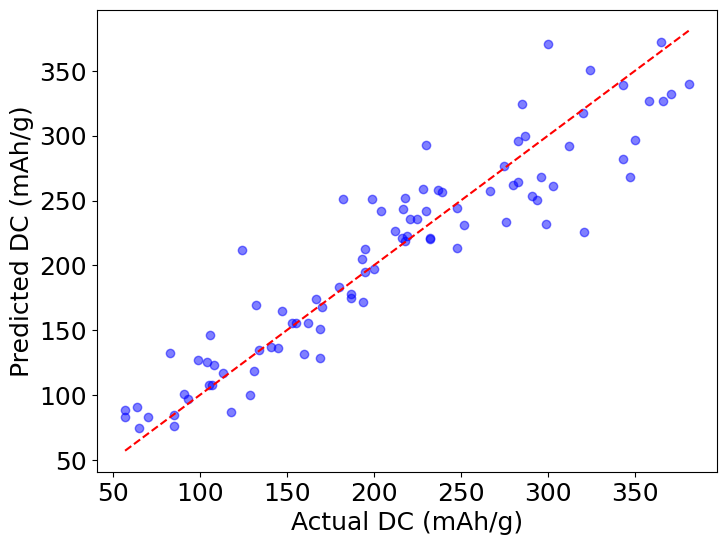

In [27]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor

# --- Preprocessing and Held-Out Test Split ---

# (Assume your DataFrame is already loaded as 'df')
if "Dopant" in df.columns:
    df = df.drop(columns=["Dopant"])

target_column = "DC"
feature_names = df.drop(columns=[target_column]).columns.tolist()

scaler = StandardScaler()
X_full = scaler.fit_transform(df.drop(columns=[target_column]).to_numpy())
y_full = df[target_column].to_numpy()

y_full_binned = pd.qcut(y_full, q=10, duplicates='drop', labels=False)

X_train_val, X_test, y_train_val, y_test, y_train_val_binned, _ = train_test_split(
    X_full, y_full, y_full_binned, test_size=0.15, random_state=42, stratify=y_full_binned
)

# --- Define the Objective Function with Stratified K-Fold CV ---

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    r2_scores = []
    
    for train_index, val_index in skf.split(X_train_val, y_train_val_binned):
        X_train_fold, X_val_fold = X_train_val[train_index], X_train_val[val_index]
        y_train_fold, y_val_fold = y_train_val[train_index], y_train_val[val_index]
        
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train_fold, y_train_fold)
        
        preds = model.predict(X_val_fold)
        r_squared = r2_score(y_val_fold, preds)
        r2_scores.append(r_squared)
    
    return np.mean(r2_scores)

# --- Hyperparameter Optimization using Optuna ---
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# --- Final Model Training on Full Training Data ---
best_model = RandomForestRegressor(
    n_estimators=study.best_params["n_estimators"],
    max_depth=study.best_params["max_depth"],
    min_samples_split=study.best_params["min_samples_split"],
    min_samples_leaf=study.best_params["min_samples_leaf"],
    random_state=42,
    n_jobs=-1
)
best_model.fit(X_train_val, y_train_val)

# ---------Evaluation on Train Data--------------
y_pred_train_val = best_model.predict(X_train_val_scaled)

# Calculate adjusted R²
n = X_train_val.shape[0]
p = X_train_val.shape[1]

metrics = {
    "Mean Squared Error (MSE)": mean_squared_error(y_train_val, y_pred_train_val),
    "Root Mean Squared Error (RMSE)": np.sqrt(mean_squared_error(y_train_val, y_pred_train_val)),
    "Mean Absolute Error (MAE)": mean_absolute_error(y_train_val, y_pred_train_val),
    "R² Score": r2_score(y_train_val, y_pred_train_val),
    "Adjusted R² Score": 1 - (1 - r2_score(y_train_val, y_pred_train_val)) * (n - 1) / (n - p - 1)
}

print("Train Evaluation Metrics:")
print(metrics)

# ---------Evaluation on Test Data--------------
y_pred = best_model.predict(X_test)

# Compute evaluation metrics
n = len(y_test)
p = X_test.shape[1]
metrics = {
    "Mean Squared Error (MSE)": mean_squared_error(y_test, y_pred),
    "Root Mean Squared Error (RMSE)": np.sqrt(mean_squared_error(y_test, y_pred)),
    "Mean Absolute Error (MAE)": mean_absolute_error(y_test, y_pred),
    "R² Score": r2_score(y_test, y_pred),
    "Adjusted R² Score": 1 - (1 - r2_score(y_test, y_pred)) * (n - 1) / (n - p - 1)
}

print("Test Evaluation Metrics:")
print(metrics)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.xlabel("Actual DC (mAh/g)")
plt.ylabel("Predicted DC (mAh/g)")
plt.savefig("Regression_Test_RF.svg", format='svg')
plt.show()

## XGBoost

In [29]:
# Import necessary libraries
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold
import shap

# --- Preprocessing and Held-Out Test Split ---

# Check if "Dopant" exists in the DataFrame
if "Dopant" in df.columns:
    # Save the Dopant column separately for future use
    dopant_column = df["Dopant"]
    df_no_dopant = df.drop(columns=["Dopant"])  # Drop the column temporarily for training
else:
    raise ValueError("The column 'Dopant' is not found in the DataFrame!")

# Define Features and Target
target_column = "DC"
# Save feature names for later use in SHAP plots
feature_names = df_no_dopant.drop(columns=[target_column]).columns.tolist()

X_full = df_no_dopant.drop(columns=[target_column]).to_numpy()  # Convert to NumPy array
y_full = df_no_dopant[target_column].to_numpy()  # Continuous target

# To enable stratification even for regression, we bin the target
y_full_binned = pd.qcut(y_full, q=10, duplicates='drop', labels=False)

# Split into training+validation and held-out test sets (e.g., 85%/15%)
X_train_val, X_test, y_train_val, y_test, y_train_val_binned, y_test_binned = train_test_split(
    X_full, y_full, y_full_binned, test_size=0.15, random_state=42, stratify=y_full_binned
)

# Also split the Dopant column for the test set
_, test_dopant_column = train_test_split(
    dopant_column, test_size=0.15, random_state=42, stratify=y_full_binned
)

# --- Define the Objective Function with Stratified K-Fold CV ---
def objective(trial):
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }
    
    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    r2_scores_val = []
    
    for train_index, val_index in skf.split(X_train_val, y_train_val_binned):
        X_train_fold, X_val_fold = X_train_val[train_index], X_train_val[val_index]
        y_train_fold, y_val_fold = y_train_val[train_index], y_train_val[val_index]
        
        # Standardization
        scaler = StandardScaler()
        X_train_fold_scaled = scaler.fit_transform(X_train_fold)
        X_val_fold_scaled = scaler.transform(X_val_fold)
        
        # Train the XGBoost model
        model = XGBRegressor(**params, objective="reg:squarederror")
        model.fit(X_train_fold_scaled, y_train_fold, 
                  eval_set=[(X_val_fold_scaled, y_val_fold)], verbose=False)

        # Validation R²
        preds = model.predict(X_val_fold_scaled)
        r2_scores_val.append(r2_score(y_val_fold, preds))
    
    return np.mean(r2_scores_val)

# --- Hyperparameter Optimization using Optuna ---
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

best_params = study.best_params
print(f"Best params: {best_params}")

[I 2025-05-04 11:29:10,336] A new study created in memory with name: no-name-2d77614d-344e-4c36-b2f1-494276b075b7
[I 2025-05-04 11:29:11,948] Trial 0 finished with value: 0.7810201287269593 and parameters: {'n_estimators': 485, 'max_depth': 4, 'learning_rate': 0.032175670850225525, 'subsample': 0.6383044591159585, 'colsample_bytree': 0.7848454634109067, 'gamma': 1.0138560007428836, 'reg_lambda': 2.9531682049489243, 'reg_alpha': 2.1821568690262536, 'min_child_weight': 1}. Best is trial 0 with value: 0.7810201287269593.
[I 2025-05-04 11:29:12,799] Trial 1 finished with value: 0.7577531695365906 and parameters: {'n_estimators': 206, 'max_depth': 7, 'learning_rate': 0.06379296744279701, 'subsample': 0.5238861294762744, 'colsample_bytree': 0.6664455479390567, 'gamma': 3.0645704084077523, 'reg_lambda': 2.9944173417843007, 'reg_alpha': 4.146459555004597, 'min_child_weight': 9}. Best is trial 0 with value: 0.7810201287269593.
[I 2025-05-04 11:29:13,787] Trial 2 finished with value: 0.066379690

Best params: {'n_estimators': 462, 'max_depth': 3, 'learning_rate': 0.29518891395732294, 'subsample': 0.9282803080714245, 'colsample_bytree': 0.6146031116978727, 'gamma': 3.3014003750312284, 'reg_lambda': 2.823347937479932, 'reg_alpha': 2.3545570569348895, 'min_child_weight': 3}


In [30]:
plt.rcParams.update({'font.size': 18})

Train Evaluation Metrics:
{'Mean Squared Error (MSE)': 274.59977551347947, 'Root Mean Squared Error (RMSE)': 16.5710523357293, 'Mean Absolute Error (MAE)': 10.60912264655618, 'R² Score': 0.9662720561027527, 'Adjusted R² Score': 0.9655961454034091}
CSV test file saved successfully!
Test Evaluation Metrics:
{'Mean Squared Error (MSE)': 594.5865601095786, 'Root Mean Squared Error (RMSE)': 24.384145671103152, 'Mean Absolute Error (MAE)': 17.148840628729925, 'R² Score': 0.9207823276519775, 'Adjusted R² Score': 0.9107547741902026}


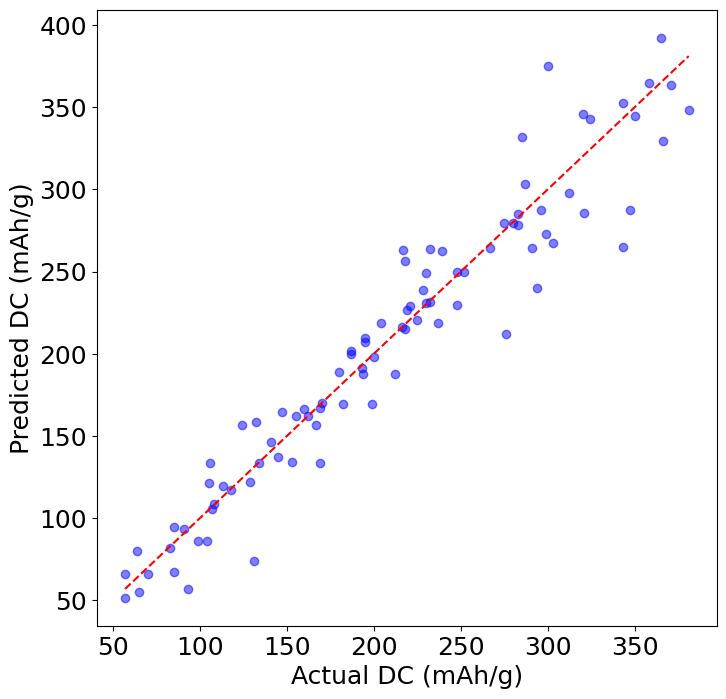

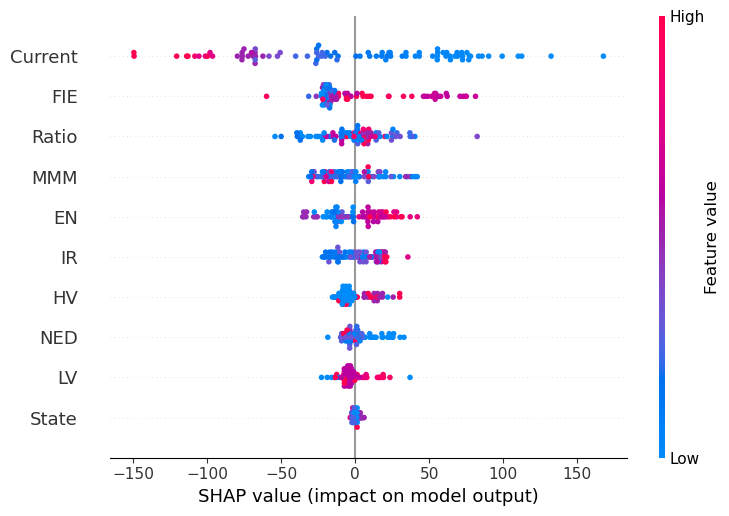

In [31]:
# --- Final Model Training ---
scaler_final = StandardScaler()
X_train_val_scaled = scaler_final.fit_transform(X_train_val)
X_test_scaled = scaler_final.transform(X_test)

best_model = XGBRegressor(**best_params, objective="reg:squarederror")
best_model.fit(X_train_val_scaled, y_train_val)

y_pred_train_val = best_model.predict(X_train_val_scaled)

# Calculate adjusted R²
n = X_train_val.shape[0]
p = X_train_val.shape[1]

metrics = {
    "Mean Squared Error (MSE)": mean_squared_error(y_train_val, y_pred_train_val),
    "Root Mean Squared Error (RMSE)": np.sqrt(mean_squared_error(y_train_val, y_pred_train_val)),
    "Mean Absolute Error (MAE)": mean_absolute_error(y_train_val, y_pred_train_val),
    "R² Score": r2_score(y_train_val, y_pred_train_val),
    "Adjusted R² Score": 1 - (1 - r2_score(y_train_val, y_pred_train_val)) * (n - 1) / (n - p - 1)
}

print("Train Evaluation Metrics:")
print(metrics)
# --- Evaluate on Held-Out Test Set ---
y_pred = best_model.predict(X_test_scaled)

# Save predictions and ground truth
output_df = pd.DataFrame({'ground_truth': y_test, 'prediction': y_pred})
output_df.to_csv('output.csv', index=False)
print('CSV test file saved successfully!')

# Calculate adjusted R²
n = X_test_scaled.shape[0]
p = X_test_scaled.shape[1]

# Compute Evaluation Metrics
metrics = {
    "Mean Squared Error (MSE)": mean_squared_error(y_test, y_pred),
    "Root Mean Squared Error (RMSE)": np.sqrt(mean_squared_error(y_test, y_pred)),
    "Mean Absolute Error (MAE)": mean_absolute_error(y_test, y_pred),
    "R² Score": r2_score(y_test, y_pred),
    "Adjusted R² Score": 1 - (1 - r2_score(y_test, y_pred)) * (n - 1) / (n - p - 1)
}

print("Test Evaluation Metrics:")
print(metrics)

# Plot Predictions vs Actual Values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
# plt.scatter(y_pred_train_val, y_pred_train_val, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.xlabel("Actual DC (mAh/g)")
plt.ylabel("Predicted DC (mAh/g)")
plt.savefig("Regression_Test_XGBoost.svg", format='svg')
plt.show()

# --- SHAP Value Analysis ---

# Initialize SHAP's JS visualization (if running in a Jupyter Notebook)
shap.initjs()

# Create a TreeExplainer for the final model
explainer = shap.TreeExplainer(best_model)

# Compute SHAP values for the training+validation set (scaled)
shap_values = explainer.shap_values(X_test_scaled)

# Generate a SHAP summary plot
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names, show=False)
plt.savefig("Shap_XGBoost.svg", format='svg', bbox_inches='tight')

### Dependence Plot

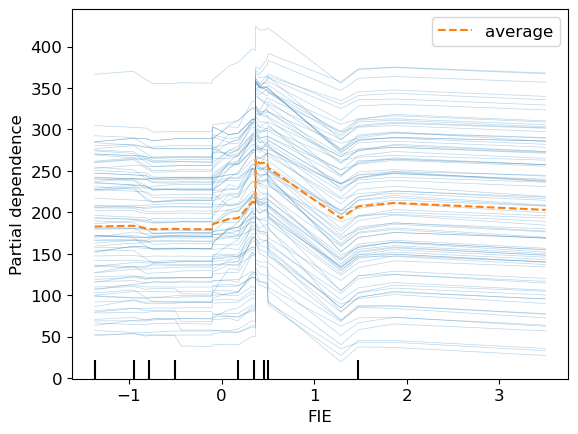

In [24]:
from sklearn.inspection import PartialDependenceDisplay
plt.rcParams.update({'font.size': 12})
PartialDependenceDisplay.from_estimator(best_model, X_test_scaled, [4],
    kind='both', feature_names = feature_names)
plt.savefig("ICE_PD_plot_FIE.svg")

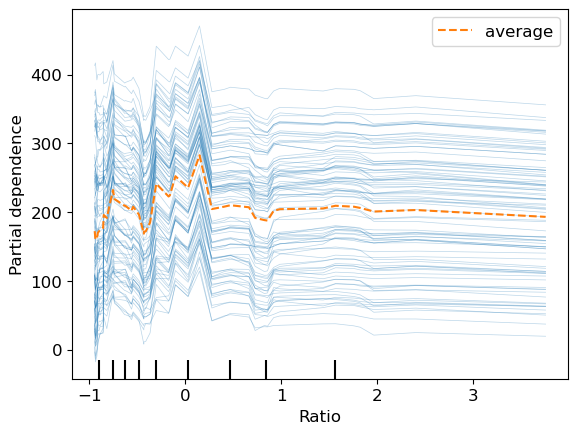

In [32]:
from sklearn.inspection import PartialDependenceDisplay
plt.rcParams.update({'font.size': 12})
PartialDependenceDisplay.from_estimator(best_model, X_test_scaled, [5],
    kind='both', feature_names = feature_names)
plt.savefig("ICE_PD_plot_Ratio.svg")

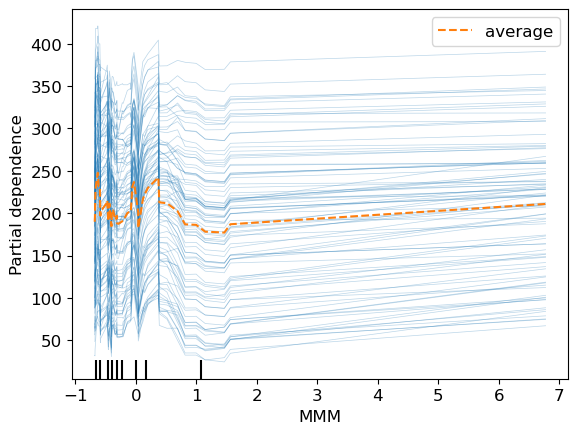

In [33]:
from sklearn.inspection import PartialDependenceDisplay
plt.rcParams.update({'font.size': 12})
PartialDependenceDisplay.from_estimator(best_model, X_test_scaled, [6],
    kind='both', feature_names = feature_names)
plt.savefig("ICE_PD_plot_MMM.svg")

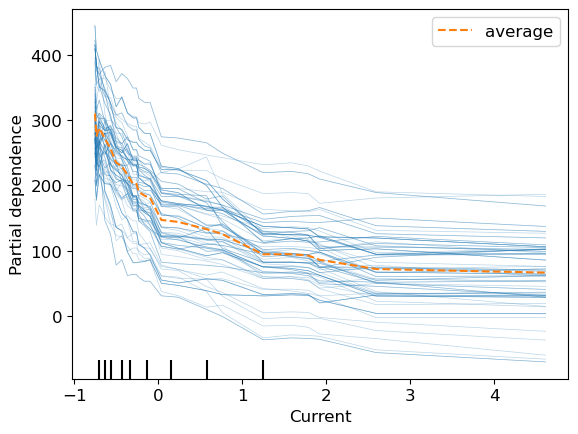

In [34]:
from sklearn.inspection import PartialDependenceDisplay
plt.rcParams.update({'font.size': 12})
PartialDependenceDisplay.from_estimator(best_model, X_test_scaled, [9],
    kind='both', feature_names = feature_names)
plt.savefig("ICE_PD_plot_Current.svg")

### SHAP cohort without unknown

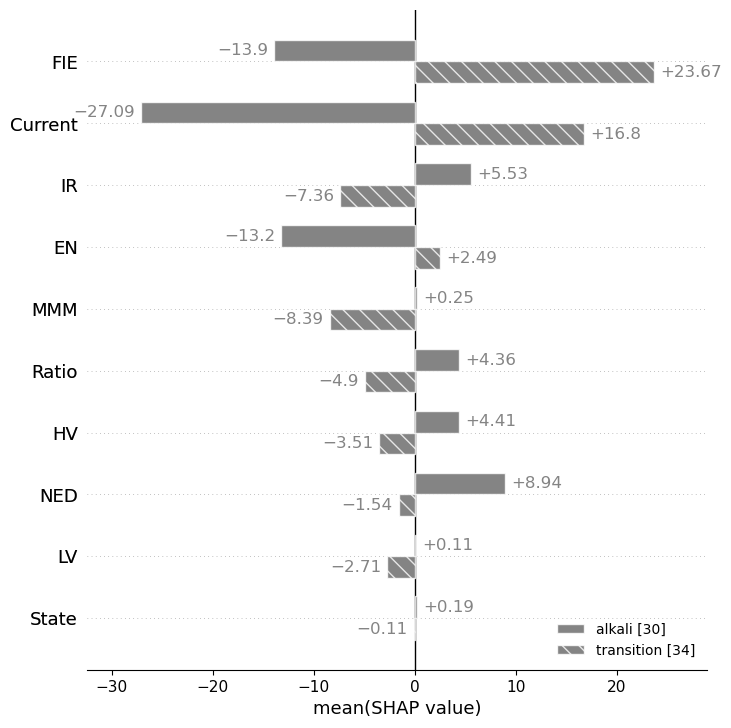

In [35]:
plt.rcParams.update({'font.size': 10})
# --- SHAP Analysis with Cohort Bar Plot ---
if test_dopant_column is not None:
    import matplotlib.patches as mpatches  # For creating custom legend entries

    # Define dopant groups
    dopant_groups = {
        "transition": {'Mo', 'Cr', 'V', 'Ti', 'Zn', 'Cu', 'Fe', 'Co', 'Ag', 'Ni'},
        "alkali": {'Ca', 'Na', 'K', 'Li', 'Mg'}
    }
    # Map dopants to groups
    dopant_mapping = {dopant: group for group, dopants in dopant_groups.items() for dopant in dopants}

    # Map the Dopant column to its respective group
    dopant_groups_test = test_dopant_column.map(dopant_mapping)

    # Filter rows without "unknown" groups
    valid_indices = dopant_groups_test.notna()  # Retain rows where group is valid
    dopant_groups_test_filtered = dopant_groups_test[valid_indices]  # Filter Dopant groups
    X_test_scaled_filtered = X_test_scaled[valid_indices]  # Filter test data

    # Compute SHAP values
    explainer = shap.TreeExplainer(best_model)
    shap_values_test = explainer(X_test_scaled_filtered)

    # Wrap SHAP values in an Explanation object with feature names
    shap_values_test_with_names = shap.Explanation(
        values=shap_values_test,
        base_values=explainer.expected_value,
        data=X_test_scaled_filtered,
        feature_names=feature_names
    )

    # Create cohorts using filtered dopant groups
    dopant_groups_test_array = dopant_groups_test_filtered.to_numpy()  # Convert to numpy array
    shap_cohorts = shap_values_test_with_names.cohorts(dopant_groups_test_array)

    # Apply custom colors based on cohorts in the bar plot
    bar_plot = shap.plots.bar(shap_cohorts.mean(0), show=False)  # Raw SHAP values now used

    plt.legend(loc="lower right", frameon=False)

    # Save the plot if needed
    plt.savefig("SHAP_Cohort_Bar_Plot_Cohort_without_unknown.svg", format='svg', bbox_inches='tight')
else:
    print("No 'Dopant' column found for SHAP cohort analysis!")
